<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/CIFAR_QNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 3.0MB/s 
     |████████████████████████████████| 18.0MB 214kB/s 
     |████████████████████████████████| 235kB 41.4MB/s 
     |████████████████████████████████| 215kB 37.8MB/s 
     |████████████████████████████████| 2.1MB 35.1MB/s 
     |████████████████████████████████| 1.5MB 21.5MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 194kB 51.6MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 614kB 37.2MB/s 
     |████████████████████████████████| 3.2MB 36.0MB/s 
     |████████████████████████████████| 6.3MB 30.3MB/s 
  Created wheel for qiskit: filename=qiskit-0.26.2-cp37-none-any.whl size=10506 sha256=f8404b2ac0bd10d29ea44c58a96c45268b4277fe59530e2dcef698c9ee064986
  Stored in directory: /root/.cache/pip/wheels/89/89/34/524839952d5a58a7be9789e580bfc1ca883bf6579152444568
  Created wheel for python-constraint: filename=python_constraint-1.4.0-

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [4]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [13]:

import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

In [6]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

In [ ]:
#import torchvision
#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
#cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

#labels = cifar_trainset.targets # get the labels for the data
#labels = labels.numpy()

#idx1 = np.where(labels == 0) # filter on aeroplanes
#idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
#n=100

# concatenate the data indices
#idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
#cifar_trainset.targets = labels[idx] 
#cifar_trainset.data = cifar_trainset.data[idx]

#train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)

In [10]:
import tensorflow
import torchvision

In [7]:

import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


Now creating the hybrid neural network.

In [8]:

qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(500, 500)
        self.h2 = nn.Linear(500, 1)

    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x

-0.4875499999999999
-0.53685
-0.6149999999999999
-0.6357499999999997
-0.6357999999999999
-0.6444500000000001
-0.61705
-0.6034000000000003
-0.62235
-0.6360999999999997
-0.65685
-0.6769499999999998
-0.7017500000000001
-0.6882500000000001
-0.6798999999999995


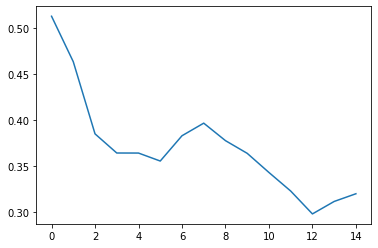

In [15]:
network = Net()
#input = input.permute(1,0,2,3)
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 15
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

# Plot the loss per epoch
plt.plot(loss_list)

-0.4462999999999998
-0.48209999999999986
-0.54845
-0.5301499999999999
-0.4999499999999999


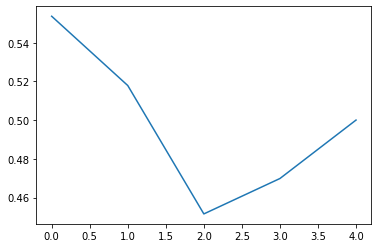

In [16]:
network = Net()
#input = input.permute(1,0,2,3)
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 5
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

# Plot the loss per epoch
plt.plot(loss_list)

-0.5118499999999999
-0.5955
-0.6082499999999997
-0.62025
-0.6203000000000001
-0.639
-0.6474499999999999
-0.6445499999999998
-0.6512000000000002
-0.6466499999999997


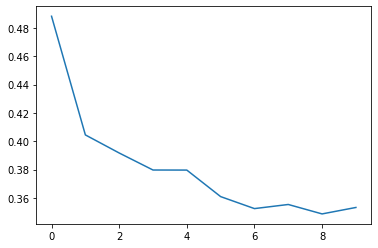

In [17]:
network = Net()
#input = input.permute(1,0,2,3)
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 15
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

# Plot the loss per epoch
plt.plot(loss_list)

-0.5045999999999996
-0.5156000000000002
-0.5200000000000002
-0.4934999999999996
-0.5202500000000001
-0.5209000000000004
-0.5336000000000002
-0.49290000000000006
-0.48045000000000015
-0.5233499999999998
-0.5056500000000003
-0.5237
-0.5123000000000002
-0.5181499999999999
-0.52935
-0.4889500000000001
-0.4843500000000001
-0.4914999999999998
-0.5487000000000002
-0.5341000000000002


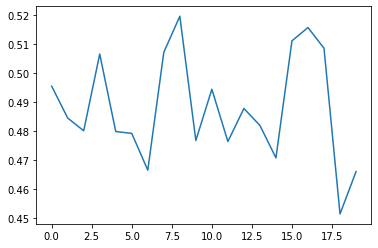

In [18]:
network = Net()
#input = input.permute(1,0,2,3)
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 20
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

# Plot the loss per epoch
plt.plot(loss_list)

In [19]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.4948
Training [10%]	Loss: -0.5350
Training [15%]	Loss: -0.5174
Training [20%]	Loss: -0.5327
Training [25%]	Loss: -0.5093
Training [30%]	Loss: -0.5253
Training [35%]	Loss: -0.4722
Training [40%]	Loss: -0.4759
Training [45%]	Loss: -0.5167
Training [50%]	Loss: -0.5351
Training [55%]	Loss: -0.4894
Training [60%]	Loss: -0.5097
Training [65%]	Loss: -0.4912
Training [70%]	Loss: -0.5209
Training [75%]	Loss: -0.4855
Training [80%]	Loss: -0.5287
Training [85%]	Loss: -0.4939
Training [90%]	Loss: -0.4965
Training [95%]	Loss: -0.5194
Training [100%]	Loss: -0.4810


Text(0, 0.5, 'Neg Log Likelihood Loss')

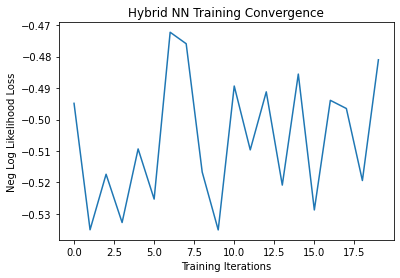

In [20]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

We now attempt to test the network

In [21]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

NameError: ignored

In [48]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels1 = cifar_testset.targets # get the labels for the data
labels1 = np.array(labels1)

idx1_ae = np.where(labels1 == 0) # filter on aeroplanes
idx2_au = np.where(labels1 == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)

n=50

# concatenate the data indices
idxa = np.concatenate((idx1_ae[0][0:n],idx2_au[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idxa] 
cifar_testset.data = cifar_testset.data[idxa]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


In [82]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

IndexError: ignored

In [81]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(500, 500)
        self.h2 = nn.Linear(500, 11)

    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x